# **Import Libraries**

In [1]:
import os
import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp

from sklearn.model_selection import train_test_split
#from nltk.translate.bleu_score import corpus_bleu
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import json
import pandas as pd
from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator
import warnings
warnings.filterwarnings("ignore")

# **Defining Hyperparameters**

In [3]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224-in21k"
    DECODER = "bert-base-uncased"
    IMG_SIZE = (224,224)
   

In [4]:
from transformers import ViTConfig, BertConfig, VisionEncoderDecoderConfig, VisionEncoderDecoderModel

config_decoder = BertConfig()
config_encoder = ViTConfig()
config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)

model = VisionEncoderDecoderModel(config = config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

# **Tokenizer**

In [5]:
# image feature extractor
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained(config.ENCODER)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)

In [6]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
model.config.decoder_start_token_id = tokenizer.cls_token_id

In [7]:
model_name = 'vit-bert_v0.0'

model_dir = f'./models/{model_name}'
model_output_dir = f'{model_dir}/image-captioning-output'
output_dir = f'{model_dir}/vit-bert-model'

# **Defining Evalution Matrix**

In [1]:
pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 82.5 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 59.1 

In [2]:
pip install nltk==3.8.1

Note: you may need to restart the kernel to use updated packages.


In [9]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

In [10]:
import numpy as np
import evaluate
ignore_pad_token_for_loss = True

metric = evaluate.load("rouge")
meteor = evaluate.load('meteor')

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

import nltk.translate.bleu_score as bleu

# Thêm hàm tính BLEU scores
def compute_bleu(preds, labels, n):
    bleu_scores = []
    for pred, label in zip(preds, labels):
        pred_tokens = nltk.word_tokenize(pred.lower())
        label_tokens = nltk.word_tokenize(label.lower())
        bleu_score = bleu.sentence_bleu([label_tokens], pred_tokens, weights=[1.0/n]*n)
        bleu_scores.append(bleu_score)
    return bleu_scores


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    # Compute BLEU@1 and BLEU@2
    bleu1_scores = compute_bleu(decoded_preds, decoded_labels, 1)
    bleu2_scores = compute_bleu(decoded_preds, decoded_labels, 2)
    bleu3_scores = compute_bleu(decoded_preds, decoded_labels, 3)
    bleu4_scores = compute_bleu(decoded_preds, decoded_labels, 4)

    # Compute ROUGE scores
    rouge_scores = metric.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  use_stemmer=True)
    rouge_scores = {k: round(v * 100, 4) for k, v in rouge_scores.items()}
    
    meteor_scores = meteor.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  )

    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    gen_len_mean = np.mean(prediction_lens)

    result = {
        "bleu_1": round(np.mean(bleu1_scores) * 100, 4),
        "bleu_2": round(np.mean(bleu2_scores) * 100, 4),
        "bleu_3": round(np.mean(bleu3_scores) * 100, 4),
        "bleu_4": round(np.mean(bleu4_scores) * 100, 4),
        **rouge_scores,
        "meteor": round(meteor_scores['meteor']*100, 4),
        "gen_len": gen_len_mean
    }
    return result


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **Normalization Of Image**

In [11]:
from torchvision import io, transforms
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)

# **Loading Dataset**

In [12]:
import pandas as pd
df = pd.read_csv('fashion/output.csv')

In [13]:
df = df.iloc[:20000]

In [14]:
from sklearn.model_selection import train_test_split
dtrain , dval = train_test_split(df , test_size = 0.2)

# **Load Image For Training**

In [15]:
from PIL import Image
import torch


class ImageCapatioingDataset(torch.utils.data.Dataset):
    def __init__(self, df,root_dir,max_target_length, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.max_target_length = max_target_length

    def __getitem__(self, idx):
        image = self.df.image.iloc[idx]
        image_path = os.path.join(self.root_dir , image)
        caption = self.df.caption.iloc[idx]
        model_inputs = dict()
        model_inputs['labels'] = self.tokenization_fn(caption, self.max_target_length)
        model_inputs['pixel_values'] = self.feature_extraction_fn(image_path)
        return model_inputs

    def __len__(self):
        return len(self.df)
    
    # text preprocessing step
    def tokenization_fn(self, caption, max_target_length):
        labels = tokenizer(caption, 
                          padding="max_length", 
                          max_length=max_target_length,
                          truncation=True).input_ids

        return labels
    
    # image preprocessing step
    def feature_extraction_fn(self, image_path):
        image = Image.open(image_path).convert('RGB')

        encoder_inputs = feature_extractor(images=image, return_tensors="np")

        return encoder_inputs.pixel_values[0]


train_dataset = ImageCapatioingDataset(dtrain, root_dir = "fashion/images/",max_target_length = 64,transform = transforms)
val_dataset = ImageCapatioingDataset(dval, root_dir = "fashion/images/",max_target_length = 64,transform = transforms)

# **Model Initialization**

# **Training**

In [16]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    output_dir=model_output_dir,
    num_train_epochs = 20,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [17]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss,Bleu 1,Bleu 2,Bleu 3,Bleu 4,Rouge1,Rouge2,Rougel,Rougelsum,Meteor,Gen Len
1,No log,0.502110,49.072400,37.279600,29.671200,23.499000,55.841300,34.493500,50.829600,51.765600,51.005000,29.317750
2,0.904100,0.385439,52.170800,40.820800,33.105800,27.115900,59.313700,38.468700,54.228000,55.020500,54.484800,29.367500
3,0.904100,0.329054,56.975100,46.222300,38.840800,32.970900,63.801600,43.900700,58.735100,59.606400,59.514700,29.742750
4,0.327500,0.301167,58.280900,47.767900,40.679800,34.942300,64.878600,45.473700,60.004000,60.859500,60.587500,30.149750
5,0.327500,0.285053,60.086400,49.910000,42.923300,37.175000,66.413300,47.506800,61.538200,62.441200,62.490000,30.151000
6,0.221900,0.275061,60.903400,50.900400,43.995700,38.366700,67.359700,48.694800,62.505000,63.380900,62.824700,29.670500
7,0.221900,0.268972,61.518500,51.829200,45.053900,39.432700,68.107300,49.973400,63.354700,64.293300,63.585800,30.005000
8,0.152600,0.269631,62.329500,52.908600,46.418200,41.108200,68.758600,51.138300,64.313400,65.141300,64.152400,29.512250
9,0.152600,0.270858,63.484200,54.111200,47.606600,42.236600,69.572200,52.055200,65.071600,65.945200,65.328000,30.145750
10,0.103200,0.275562,63.126200,53.842000,47.378400,42.069400,69.288400,51.865600,64.819500,65.763800,64.916000,29.754000


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingfac

TrainOutput(global_step=5000, training_loss=0.1908747215270996, metrics={'train_runtime': 18616.1197, 'train_samples_per_second': 17.189, 'train_steps_per_second': 0.269, 'total_flos': 5.792839957610496e+19, 'train_loss': 0.1908747215270996, 'epoch': 20.0})

In [18]:
trainer.save_model(model_output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


In [19]:
tokenizer.save_pretrained(model_output_dir)

('./models/vit-bert_v0.0/image-captioning-output/tokenizer_config.json',
 './models/vit-bert_v0.0/image-captioning-output/special_tokens_map.json',
 './models/vit-bert_v0.0/image-captioning-output/vocab.txt',
 './models/vit-bert_v0.0/image-captioning-output/added_tokens.json',
 './models/vit-bert_v0.0/image-captioning-output/tokenizer.json')

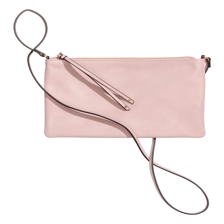

**Actual Caption**: Small bag with a narrow shoulder strap and a zip at the top. Lined. Size 16x22 cm.
**Predicted Caption**: small shoulder bag in grained imitation leather with a narrow, detachable shoulder strap, flap with a magnetic fastener, and two inner compartments. lined. size 15x24 cm.


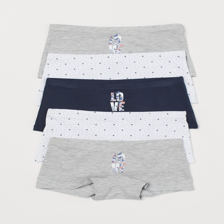

**Actual Caption**: Boxer briefs in soft, printed cotton jersey with an elasticated waist and lined gusset.
**Predicted Caption**: boxer briefs in soft, printed cotton jersey with an elasticated waist and lined gusset.


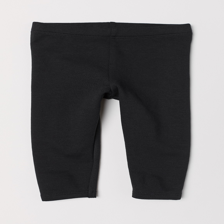

**Actual Caption**: Leggings in soft sweatshirt fabric made from an organic cotton blend with an elasticated waist. Soft brushed inside.
**Predicted Caption**: 3 / 4 - length leggings in soft organic cotton jersey with an elasticated waist.


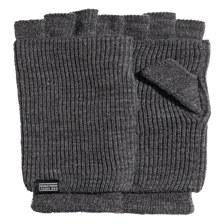

**Actual Caption**: Fine-knit fingerless gloves with matching, rib-knit wrist warmers that can be worn together or separately.
**Predicted Caption**: fine - knit fingerless gloves with ribbing at the cuffs and hem.


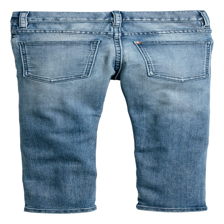

**Actual Caption**: 5-pocket slim-fit jeans in washed stretch denim with an adjustable elasticated waist, zip fly and worn details.
**Predicted Caption**: slim - fit jeans in washed, superstretch, flexible denim for maximum mobility. elasticated waist, zip fly and press - stud, fake front pockets and real back pockets.


In [29]:
import os
import random
import pandas as pd
from PIL import Image
from torchvision.transforms import functional as F
import torch
from transformers import ViTImageProcessor

model = VisionEncoderDecoderModel.from_pretrained(model_output_dir)
feature_extractor = ViTImageProcessor.from_pretrained(model_output_dir)
tokenizer = AutoTokenizer.from_pretrained(model_output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 64
num_beams = 4
gen_kwargs = {
    "max_length": max_length,
    "num_beams": num_beams,
    # "num_return_sequences": 3,
}

def load_random_image_and_caption(image_dir, captions_file):
    
    captions_df = pd.read_csv(captions_file)
    captions_df = captions_df.iloc[:20000]

    if 'image' not in captions_df.columns:
        print("Column 'image' not found in the CSV file.")
        return None, None


    random_row = captions_df.sample(n=1)
    random_image_name = random_row['image'].values[0]

    image_path = os.path.join(image_dir, random_image_name)

    if not os.path.isfile(image_path):
        print(f"Image file not found: {image_path}")
        return None, None

    if 'caption' in captions_df.columns:
        actual_caption = random_row['caption'].values[0]
    else:
        actual_caption = None

    return image_path, actual_caption

def predict_step(image_dir, captions_file):

    image_path, actual_caption = load_random_image_and_caption(image_dir, captions_file)

    if image_path is None or actual_caption is None:
        return

    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
        i_image = i_image.convert(mode="RGB")
    i_image = i_image.resize((224, 224))

    display(i_image)

    image_tensor = F.to_tensor(i_image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    output_ids = model.generate(image_tensor, **gen_kwargs)

    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    print(f"**Actual Caption**: {actual_caption}")
    print(f"**Predicted Caption**: {pred}")

image_directory = 'fashion/images'
captions_csv_file = 'fashion/output.csv'
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)